In [ ]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("/content/dataset_elpino.csv", delimiter=';', encoding='utf-8', na_values='-')

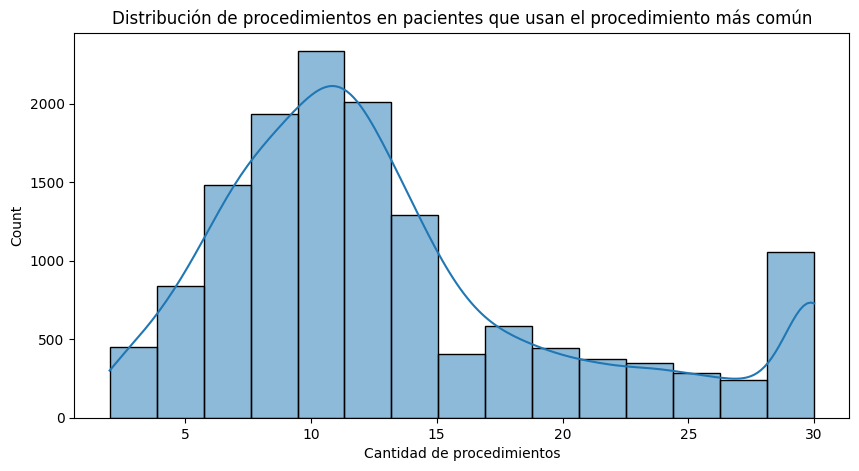

In [ ]:
def extraer_codigo(val):
    if pd.isna(val):
        return None
    return val.split(' - ')[0].strip()

columnas_diag = [col for col in df.columns if col.startswith("Diag")]
columnas_proced = [col for col in df.columns if col.startswith("Proced")]

df_diag_codigos = df[columnas_diag].map(extraer_codigo)
df_proced_codigos = df[columnas_proced].map(extraer_codigo)

df['diag_principal'] = df_diag_codigos['Diag 01 Principal (cod+des)']

# Para cada paciente, obtener lista de códigos de procedimientos
df['procedimientos_lista'] = df_proced_codigos.apply(lambda row: [p for p in row if pd.notna(p)], axis=1)

procedimientos_comunes = {}

for diag, grupo in df.groupby('diag_principal'):
    todos_procs = [proc for fila in grupo['procedimientos_lista'] for proc in fila]
    if todos_procs:
        mas_comun = Counter(todos_procs).most_common(1)[0][0]
        procedimientos_comunes[diag] = mas_comun

# Agregar columna con el procedimiento más común según diagnóstico principal
df['proc_mas_comun'] = df['diag_principal'].map(procedimientos_comunes)

# Marcar si usaron el procedimiento más común
df['usa_proc_comun'] = df.apply(lambda row: row['proc_mas_comun'] in row['procedimientos_lista'], axis=1)

# Filtrar casos sospechosos de ineficiencia
df_ineficientes = df[
    (df['usa_proc_comun']) &
    (df['n_procedimientos'] > 1)
]

# Ordenar por número de procedimientos
df_ineficientes = df_ineficientes.sort_values(by='n_procedimientos', ascending=False)

df_ineficientes[['diag_principal', 'procedimientos_lista', 'proc_mas_comun', 'n_procedimientos']]

plt.figure(figsize=(10, 5))
sns.histplot(df_ineficientes['n_procedimientos'], bins=15, kde=True)
plt.title("Distribución de procedimientos en pacientes que usan el procedimiento más común")
plt.xlabel("Cantidad de procedimientos")
plt.show()



In [ ]:
#Casos que hicieron más de 5 procedimientos
df_ineficientes[df_ineficientes['n_procedimientos'] > 5][['diag_principal', 'procedimientos_lista', 'proc_mas_comun']]

,diag_principal,procedimientos_lista,proc_mas_comun
50,U07.1,"[96.72, 88.43, 88.01, 87.41, 89.7, 93.96, 96.0...",90.59
44,U07.1,"[96.72, 33.24, 93.90, 88.43, 88.01, 88.01, 93....",90.59
14560,S06.51,"[96.71, 96.04, 87.03, 87.41, 88.01, 88.38, 87....",89.66
0,A41.8,"[86.28, 34.91, 88.38, 87.41, 88.75, 88.01, 88....",99.21
2,K56.5,"[86.22, 54.59, 96.72, 31.1, 45.13, 87.41, 87.0...",90.39
...,...,...,...
14511,F41.2,"[94.11, 99.26, 90.39, 90.59, 93.83, 89.7]",90.39
14526,K70.4,"[89.7, 90.59, 89.66, 90.39, 99.18, 99.29]",90.59
11627,T20.2,"[86.28, 99.21, 99.18, 90.39, 93.82, 89.7]",99.18
11636,O23.1,"[99.21, 90.39, 90.59, 91.39, 89.26, 89.7]",91.39
